## Goal -- how does our precision, sensitivity, and accuracy get impacted when applying the PODER filters? 

In [129]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import yaml
from snakemake.io import expand
import pyranges as pr
from pyfaidx import Fasta
from mizani.formatters import percent_format
from scipy import stats


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

from plotnine import *

In [130]:
def my_theme(base_size=11, w=4, h=3):
    """
    Custom plotnine theme with:
    - White background
    - Clean styling
    - Axes and ticks retained

    Parameters:
    - base_size: Base font size

    Returns:
    - plotnine.theme object
    """
    return (
        theme_minimal(base_size=base_size)
        + theme(
            # White background
            panel_background=element_rect(fill='white', color=None),
            plot_background=element_rect(fill='white', color=None),

            # Remove grid lines
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),

            # Keep axis lines & ticks (don't blank them)
            axis_line=element_line(color='black'),
            axis_ticks=element_line(color='black'),

            plot_title=element_text(hjust=0.5, family='Helvetica'),
            axis_title_x=element_text(hjust=0.5, family='Helvetica'),
            axis_title_y=element_text(hjust=0.5, margin={'t':0, 'r':-2, 'b':0, 'l':0}, family='Helvetica'),
            
            # Styling text
            legend_title=element_blank(),
            axis_title=element_text(size=base_size + 1, family='Helvetica'),
            legend_text=element_text(size=base_size-2, family='Helvetica'),
            axis_text=element_text(size=base_size, color='black', family='Helvetica'),
            strip_text_x=element_text(size=base_size + 1.5, family='Helvetica'),
            figure_size=(w, h),  # Controls plot dimensions (width x height in inches)
            plot_margin=0.05      # Shrinks surrounding white space
        )
    )

def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [131]:
config = load_config()
od = '../'
meta_df = load_meta()
meta_df['lab_sample'] = meta_df['lab_number_sample'].astype(str)+'_'+\
                        meta_df['lab_sampleid']+'_'+\
                        meta_df['cell_line_id']


def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

init_plot_settings()
pop_c_dict, pop_order = get_population_colors()

In [132]:
## SQANTI reads stuff
f = proc_cfg(expand(config['lr']['qc_sirvs']['sqanti_reads']['class_summary'],
                    annot_completeness='C')[0], od)
df = pd.read_csv(f, sep='\t')

# rename structural categories
m = {'antisense': 'Antisense',
     'full-splice_match': 'FSM',
     'genic': 'Genic', 
     'incomplete-splice_match': 'ISM',
     'intergenic': 'Intergenic',
     'novel_in_catalog': 'NIC',
     'novel_not_in_catalog': 'NNC'}
df['structural_category'] = df.structural_category.map(m)

# add antisense gene ids as assc_gene_2
df['assc_gene_2'] = df.associated_gene
inds = df.loc[df.structural_category=='Antisense'].index
df.loc[inds, 'assc_gene_2'] = df.loc[inds, 'assc_gene_2'].str.split('_', expand=True)[1]

# add relevant metadata
df = df.merge(meta_df[['lab_sample', 'population']], 
              how='left', on='lab_sample')

# add # mapped reads 
df['n_mapped_reads'] = df.groupby('lab_sample')['isoform'].transform('count')

# add spike type
df['spike_type'] = np.nan
df.loc[df.chrom.str.contains('ERCC'), 'spike_type'] = 'ERCC'
df.loc[df.chrom.str.contains('SIRV'), 'spike_type'] = 'SIRV'

spliced_sirvs = ['SIRV1', 'SIRV2', 'SIRV3', 'SIRV4', 'SIRV5', 'SIRV6', 'SIRV7']
df.loc[df.chrom.isin(spliced_sirvs), 'spike_type_2'] = 'spliced_sirv'

# add # spliced sirv reads
df['n_spliced_sirv_reads'] = df.loc[df.spike_type_2=='spliced_sirv'].groupby('lab_sample')['isoform'].transform('count')

# splicing novelty
df['splicing_novelty'] = 'Novel'
df.loc[df.structural_category.isin(['FSM', 'ISM']), 'splicing_novelty'] = 'Known'

# overal known vs. novel
df['overall_nov'] = 'Novel'
df.loc[df.structural_category == 'FSM', 'overall_nov'] = 'Known'

## Ground truth sirv / ercc gtf
gtf_df = pr.read_gtf('../data/qc_sirvs/SIRV_ERCC_longSIRV_multi-fasta_20210507.gtf').df

temp = gtf_df.loc[gtf_df.Chromosome.isin(spliced_sirvs)]
n_spliced_sirvs_tot = len(temp.transcript_id.unique())

# there are 69 spliced sirvs as ground truth

# get the transcript length of each sirv transcript
gtf_df['exon_len'] = gtf_df['End'] - gtf_df['Start']
gtf_df['transcript_len'] = gtf_df.groupby('transcript_id')['exon_len'].transform('sum')

gtf_df['mean_transcript_len'] = gtf_df.groupby('gene_id')['transcript_len'].transform('mean')
gtf_df['med_transcript_len'] = gtf_df.groupby('gene_id')['transcript_len'].transform('median')

# also get number of exons
gtf_df['n_exons'] = gtf_df.groupby('transcript_id')['exon_assignment'].transform('count')
gtf_df['mean_n_exons'] = gtf_df.groupby('gene_id')['n_exons'].transform('mean')
gtf_df['med_n_exons'] = gtf_df.groupby('gene_id')['n_exons'].transform('median')

# also get number of transcripts
gtf_df['n_transcripts'] = gtf_df.groupby('gene_id')['transcript_id'].transform('nunique')

# get # monoexonic transcripts
temp = gtf_df[['gene_id', 'transcript_id', 'n_exons']].groupby(['gene_id', 'n_exons']).nunique().reset_index()
temp = temp.loc[temp.n_exons==1]
temp.drop('n_exons', axis=1, inplace=True)
temp.rename({'transcript_id': 'n_monoexonic_transcripts'}, axis=1, inplace=True)
temp.loc[temp.gene_id=='SIRV6']
gtf_df = gtf_df.merge(temp,
                      how='left',
                      on='gene_id')

# sort the long sirvs at least by length
sirv_order = ['1', '2', '3', '4', '5', '6', '7',
              '4001', '4002', '4003',
              '6001', '6002', '6003', 
              '8001', '8002', '8003',
              '10001', '10002', '10003',
              '12001', '12002', '12003']
sirv_order = [f'SIRV{s}' for s in sirv_order]

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_89553/2818831187.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ERCC' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


## Experimental protocol efficacy: How often are reads incorrect (novel)?

In [133]:
temp = df.loc[df.spike_type_2=='spliced_sirv']
gb_cols = ['structural_category','lab_sample', 'n_spliced_sirv_reads', 'n_mapped_reads', 'population']
keep_cols = gb_cols+['isoform']
temp = temp[keep_cols].groupby(gb_cols).count().reset_index().rename({'isoform':'n_reads_cat'}, axis=1)
temp['perc'] = (temp.n_reads_cat/temp.n_spliced_sirv_reads)*100
# temp.head()

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_89553/1844820241.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


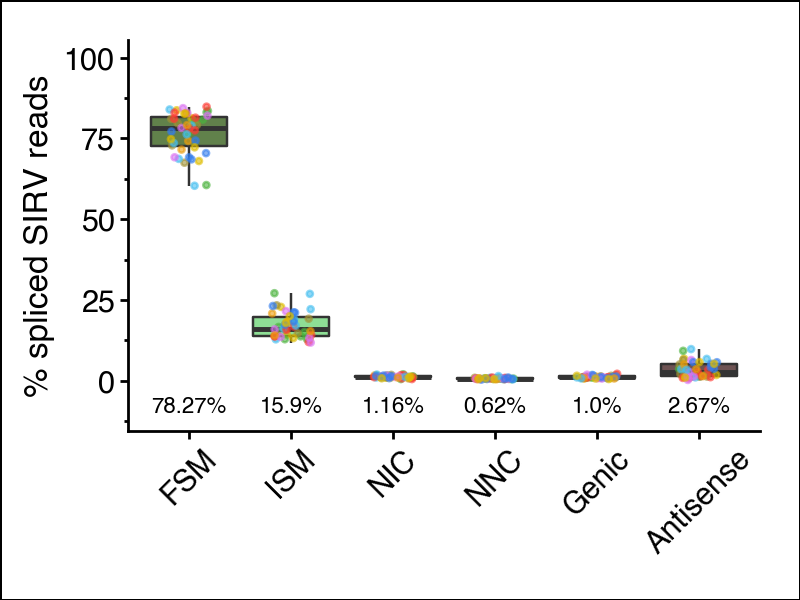

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4 x 3 in image.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: spliced_sirv_perc_reads_by_nov.pdf
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [134]:
pop_c_dict, pop_order = get_population_colors()
c_dict, order = get_novelty_colors(temp.structural_category.unique().tolist())
temp['structural_category'] = pd.Categorical(temp['structural_category'], categories=order, ordered=True)

# labels for the median per gene / metric
medians_df = (
    temp
    .groupby(['structural_category'], as_index=False)
    .agg(median_val=('perc', 'median'))
)
medians_df['y'] = -5  # adjust for spacing
medians_df['label'] = medians_df['median_val'].round(2).astype(str)+'%'


p1 = (
    ggplot(temp, aes(x='structural_category', y='perc'))
    + geom_boxplot(aes(fill='structural_category'), outlier_shape='')
    # + geom_jitter(aes(color='population', size='n_mapped_reads'), width=0.2, alpha=0.6)
    + geom_jitter(aes(color='population'), width=0.2, alpha=0.6, size=0.75)
    + scale_color_manual(values=pop_c_dict)
    + scale_fill_manual(c_dict)
    # + scale_size_continuous(range=(0.25, 2))
    + labs(
        x='',
        y='% spliced SIRV reads',
        fill='Read structural category'
    )
    + my_theme(w=4, h=3)
    + theme(axis_text_x=element_text(rotation=45))
    + theme(legend_position='none')
    + geom_text(
        aes(x='structural_category', y='y', label='label'),
        data=medians_df,
        inherit_aes=False,
        size=8,
        va='top'
    )
    + ylim(-10,100)

)
p1.show()
p1.save('spliced_sirv_perc_reads_by_nov.pdf', width=4, height=3, dpi=500)

medians_df['novelty_type'] = 'Structural category'
medians_df['splicing_struct_cat'] = medians_df['structural_category']
medians_df_back = medians_df.copy(deep=True)
temp['novelty_type'] = 'Structural category'
temp['splicing_struct_cat'] = temp['structural_category']
temp_back = temp.copy(deep=True)

In [135]:
print(temp.groupby('structural_category')['perc'].mean())
print()
print(temp.groupby('structural_category')['perc'].median())

structural_category
FSM          76.748970
ISM          17.015123
NIC           1.193413
NNC           0.638521
Genic         1.083470
Antisense     3.320503
Name: perc, dtype: float64

structural_category
FSM          78.268945
ISM          15.898960
NIC           1.161318
NNC           0.624400
Genic         0.995025
Antisense     2.674591
Name: perc, dtype: float64


/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_89553/1502042847.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_89553/1502042847.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [136]:
temp = df.loc[df.spike_type_2=='spliced_sirv']
gb_cols = ['splicing_novelty','lab_sample', 'n_spliced_sirv_reads', 'n_mapped_reads', 'population']
keep_cols = gb_cols+['isoform']
temp = temp[keep_cols].groupby(gb_cols).count().reset_index().rename({'isoform':'n_reads_cat'}, axis=1)
temp['perc'] = (temp.n_reads_cat/temp.n_spliced_sirv_reads)*100

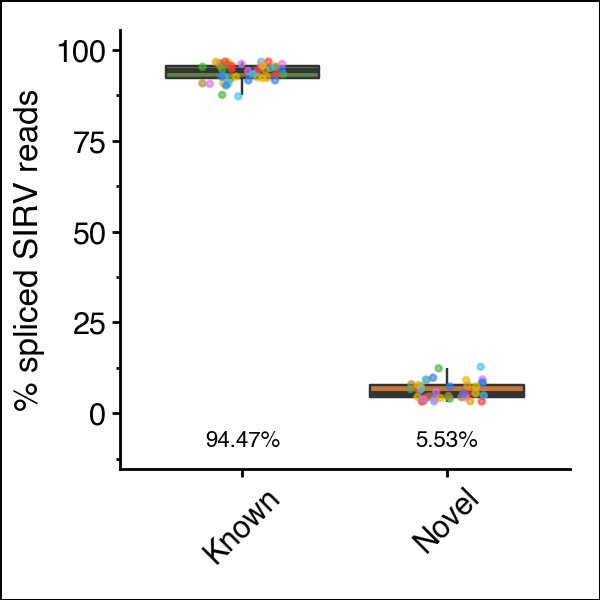

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3 x 3 in image.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: spliced_sirv_perc_reads_by_spliced_nov.pdf
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [137]:
c_dict, order = get_novelty_colors()
sn_c_dict = {'Known': c_dict['FSM'],
             'Novel': c_dict['NNC']}
sn_order = ['Known', 'Novel']

# labels for the median per gene / metric
medians_df = (
    temp
    .groupby(['splicing_novelty'], as_index=False)
    .agg(median_val=('perc', 'median'))
)
medians_df['y'] = -5  # adjust for spacing
medians_df['label'] = medians_df['median_val'].round(2).astype(str)+'%'

temp['structural_category'] = pd.Categorical(temp['splicing_novelty'], categories=sn_order, ordered=True)
p2 = (
    ggplot(temp, aes(x='splicing_novelty', y='perc'))
    + geom_boxplot(aes(fill='splicing_novelty'), outlier_shape='')
    # + geom_jitter(aes(color='population', size='n_mapped_reads'), width=0.2, alpha=0.6)
    + geom_jitter(aes(color='population'), width=0.2, alpha=0.6, size=0.75)
    + scale_color_manual(values=pop_c_dict)
    + scale_fill_manual(sn_c_dict)
    # + scale_size_continuous(range=(0.25, 2))
    + labs(
        x='',
        y='% spliced SIRV reads',
        fill='Splicing novelty'
    )
    + my_theme(w=3, h=3)
    + theme(axis_text_x=element_text(rotation=45))
    + theme(legend_position='none')
    + geom_text(
        aes(x='splicing_novelty', y='y', label='label'),
        data=medians_df,
        inherit_aes=False,
        size=8,
        va='top'
    )
    + ylim(-10,100)
)
p2.show()
p2.save('spliced_sirv_perc_reads_by_spliced_nov.pdf', width=3, height=3, dpi=500)

medians_df['novelty_type'] = 'Splicing novelty'
medians_df['splicing_struct_cat'] = medians_df['splicing_novelty']
temp['novelty_type'] = 'Splicing novelty'
temp['splicing_struct_cat'] = temp['splicing_novelty']

In [138]:
print(temp.groupby('splicing_novelty')['perc'].median())
print()
print(temp.groupby('splicing_novelty')['perc'].mean())
# df.loc[df.spike_type_2 == 'spliced_sirv'].associated_gene.unique()

splicing_novelty
Known    94.470546
Novel     5.529454
Name: perc, dtype: float64

splicing_novelty
Known    93.764093
Novel     6.235907
Name: perc, dtype: float64


## Transcript discovery: Apply filters and check precision and sensitivity and f1 before and after
* FSM? (pass_fsm_filter)
* Monoexonic? (pass_monoexonic_filter)
* Reproducibile for novel transcripts? (pass_reproducibility_filter)
* Promoted ISM? (promoted_ism_filter)
* ISM? (pass_ism_filter)

In [63]:
# only spliced sirvs
temp = df.loc[df.spike_type_2 == 'spliced_sirv']

# filter 1 -- novel transcripts must be present in 2+ samples
temp['sample_sharing'] = temp.groupby('jxnHash')['lab_sample'].transform('nunique')
temp.loc[temp.sample_sharing>=2, 'filter_pass'] = True

# filter 2 - for ISMs, if associated_transcript is not in original collection, add it and pass it

# first, mark all ISMs as non-passing
temp.loc[temp.structural_category=='ISM', 'filter_pass'] = False

# get a random fsm entry to add for each uniq one
fsm_temp = temp.loc[(temp.structural_category=='FSM')].drop_duplicates(subset='associated_transcript', keep='first')
fsm_temp['lab_sample'] = np.nan
assert len(fsm_temp.index) == n_spliced_sirvs_tot

# now loop through lab samples and tack on undet. entries FSMs
# for all ISMs
add_df = pd.DataFrame()
for s in temp.lab_sample.unique():
    undet_fsms_from_isms = temp.loc[(temp.lab_sample==s)&\
                                    (temp.structural_category=='ISM')]
    
    temp2 = temp.loc[temp.lab_sample==s]

    # these are the ids of transcripts that are detected via isms
    ism_fsm_ids = temp2.loc[(temp2.structural_category=='ISM'),
                           'associated_transcript'].unique().tolist()
    
    # these are the ids of transcripts that are detected via fsms
    fsm_ids = temp2.loc[(temp2.structural_category=='FSM'),
                        'associated_transcript'].unique().tolist()
    
    # the set difference will be the ones we need to "promote"
    promote_fsm_ids = list(set(ism_fsm_ids)-set(fsm_ids))
    promote_fsm_ids
    
    add_df_temp = fsm_temp.loc[fsm_temp.associated_transcript.isin(promote_fsm_ids)]
    add_df_temp['lab_sample'] = s
    add_df_temp['promoted_ism'] = True
    
    add_df = pd.concat([add_df, add_df_temp], axis=0)

temp = pd.concat([temp, add_df], axis=0)

# filter 0 -- all FSMs pass filtering
temp.loc[temp.structural_category == 'FSM', 'filter_pass'] = True

# filter 3 -- all monoexonics fail filtering 
temp.loc[temp.exons == 1, 'filter_pass'] = False

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_89553/3257686515.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_89553/3257686515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_89553/3257686515.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [64]:
# now reduce to just uniq junction chains
temp['ic_id'] = temp.jxn_string
temp.loc[temp.structural_category=='FSM', 'ic_id'] = temp.loc[temp.structural_category=='FSM', 'associated_transcript']

# annotate true positives
temp['tp'] = False
temp.loc[temp.structural_category=='FSM', 'tp'] = True

keep_cols = ['exons', 'assc_gene_2', 'population',
             'n_mapped_reads', 'spike_type', 'spike_type_2', 'n_spliced_sirv_reads',
             'splicing_novelty', 'overall_nov', 'sample_sharing', 'promoted_ism',
             'ic_id', 'filter_pass', 'lab_sample', 'tp']
temp = temp[keep_cols].drop_duplicates()

print(len(temp.index))
print(len(temp[['ic_id', 'filter_pass', 'lab_sample']].drop_duplicates()))
assert len(temp.index) == len(temp[['ic_id', 'filter_pass', 'lab_sample']].drop_duplicates())

print(len(temp.index))
print(len(temp[['ic_id', 'filter_pass', 'lab_sample', 'assc_gene_2']].drop_duplicates()))
assert len(temp.index) == len(temp[['ic_id', 'filter_pass', 'lab_sample', 'assc_gene_2']].drop_duplicates())


# now rework the df. one set of entries for filtered isoforms,
# one for unfiltered isoforms
filt_df = temp.loc[temp.filter_pass==True].copy(deep=True)
filt_df['filter_set'] = 'Filtered'
unfilt_df = temp.copy(deep=True)
unfilt_df['filter_set'] = 'Unfiltered'

temp = pd.concat([filt_df, unfilt_df], axis=0)

# also duplicate the whole thing for all w/ all as assc gene 2
temp2 = temp.copy(deep=True)
temp2['assc_gene_2'] = 'All'
temp = pd.concat([temp, temp2], axis=0)

9020
9020
9020
9020


In [70]:
stat_df = pd.DataFrame()

# add # tp for each sample / filtered vs. unfiltered / gene (also incl. all)
temp['n_det_per_cat'] = temp.groupby(['lab_sample', 'tp', 'filter_set', 'assc_gene_2'])['ic_id'].transform('nunique')
stat_df = pd.concat([stat_df, temp.loc[(temp.tp==True)][['lab_sample', 'n_det_per_cat', 'filter_set', 'assc_gene_2']].drop_duplicates()], axis=0)
stat_df.rename({'n_det_per_cat':'n_tp'}, axis=1, inplace=True)

# add # fp for each sample
temp['n_det_per_cat_2'] = temp.groupby(['lab_sample', 'overall_nov', 'filter_set', 'assc_gene_2'])['ic_id'].transform('nunique')
stat_df = stat_df.merge(temp.loc[(temp.overall_nov=='Novel')][['lab_sample', 'n_det_per_cat_2', 'filter_set', 'assc_gene_2']].drop_duplicates(), 
                       how='left',
                       on=['lab_sample', 'filter_set', 'assc_gene_2'])
stat_df.rename({'n_det_per_cat_2':'n_fp'}, axis=1, inplace=True)

# add # fn for each sample. 
stat_df = stat_df.merge(gtf_df[['gene_id', 'n_transcripts', 'n_monoexonic_transcripts']].drop_duplicates(),
                        how='left',
                        left_on='assc_gene_2',
                        right_on='gene_id')
stat_df.fillna(0, inplace=True)

# all needs help
n_all = len(gtf_df.loc[gtf_df.gene_id.isin(spliced_sirvs)].transcript_id.unique().tolist())
assert n_all == 69
stat_df.loc[stat_df.assc_gene_2 == 'All', 'n_transcripts'] = n_all
n_all_monoexonic = len(gtf_df.loc[(gtf_df.gene_id.isin(spliced_sirvs))&\
                                  (gtf_df.n_exons==1)].transcript_id.unique().tolist())
assert n_all_monoexonic == 8
stat_df.loc[stat_df.assc_gene_2 == 'All', 'n_monoexonic_transcripts'] = n_all_monoexonic


stat_df['n_fn'] = stat_df['n_transcripts']-stat_df['n_tp']

stat_df = stat_df.drop_duplicates()
assert len(stat_df.index) == 43*(7+1)*2 # 7 sirv genes + 1 "all"; filt. vs. non-filt

stat_df['prec'] = stat_df['n_tp']/(stat_df['n_tp']+stat_df['n_fp'])
stat_df['sens'] = stat_df['n_tp']/(stat_df['n_tp']+stat_df['n_fn'])
stat_df['f1'] = stat_df['n_tp']/(stat_df['n_tp']+0.5*(stat_df['n_fp']+stat_df['n_fn']))

stat_df = stat_df.merge(meta_df[['lab_sample', 'population']],
                        how='left',
                        on='lab_sample')

value_vars = ['prec', 'sens', 'f1']
stat_melted = pd.melt(
    stat_df,
    id_vars=[col for col in stat_df.columns if col not in value_vars],
    value_vars=value_vars,
    var_name='stat_type',
    value_name='stat_val')

stat_melted['stat_type'] = stat_melted.stat_type.map({'prec':'Precision',
                                                      'sens':'Sensitivity',
                                                      'f1':'F1'})

# add title for genes
stat_melted['assc_gene_title'] = stat_melted.apply(lambda x: f'{x.assc_gene_2}\n'+\
                                                   f'{int(x['n_transcripts'])} transcripts\n('+\
                                                   f'{int(x['n_monoexonic_transcripts'])} monoexonic)', axis=1)
inds = stat_melted.loc[stat_melted.n_monoexonic_transcripts==0].index
stat_melted.loc[inds, 'assc_gene_title'] = stat_melted.loc[inds].apply(lambda x: f'{x.assc_gene_2}\n'+\
                                                   f'{int(x['n_transcripts'])} transcripts', axis=1)

# order filt/ unfilt
stat_melted['filter_set'] = pd.Categorical(stat_melted['filter_set'], categories=['Unfiltered', 'Filtered'], ordered=True)

# add medians
stat_melted['median'] = stat_melted.groupby(['stat_type', 'assc_gene_title', 'filter_set'])['stat_val'].transform('median')
stat_melted['median_y'] = 0.1  
stat_melted['median_label'] = stat_melted['median'].round(2).astype(str)

# add colors
stat_melted['pop_color'] = stat_melted.population.map(pop_c_dict)

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_89553/908119037.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [71]:
stat_melted.to_csv('spliced_sirv_performance_df.tsv', sep='\t')

In [82]:
colorz = {'Filtered': 'black', 'Unfiltered': 'gray'}

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/guides/guides.py:207: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


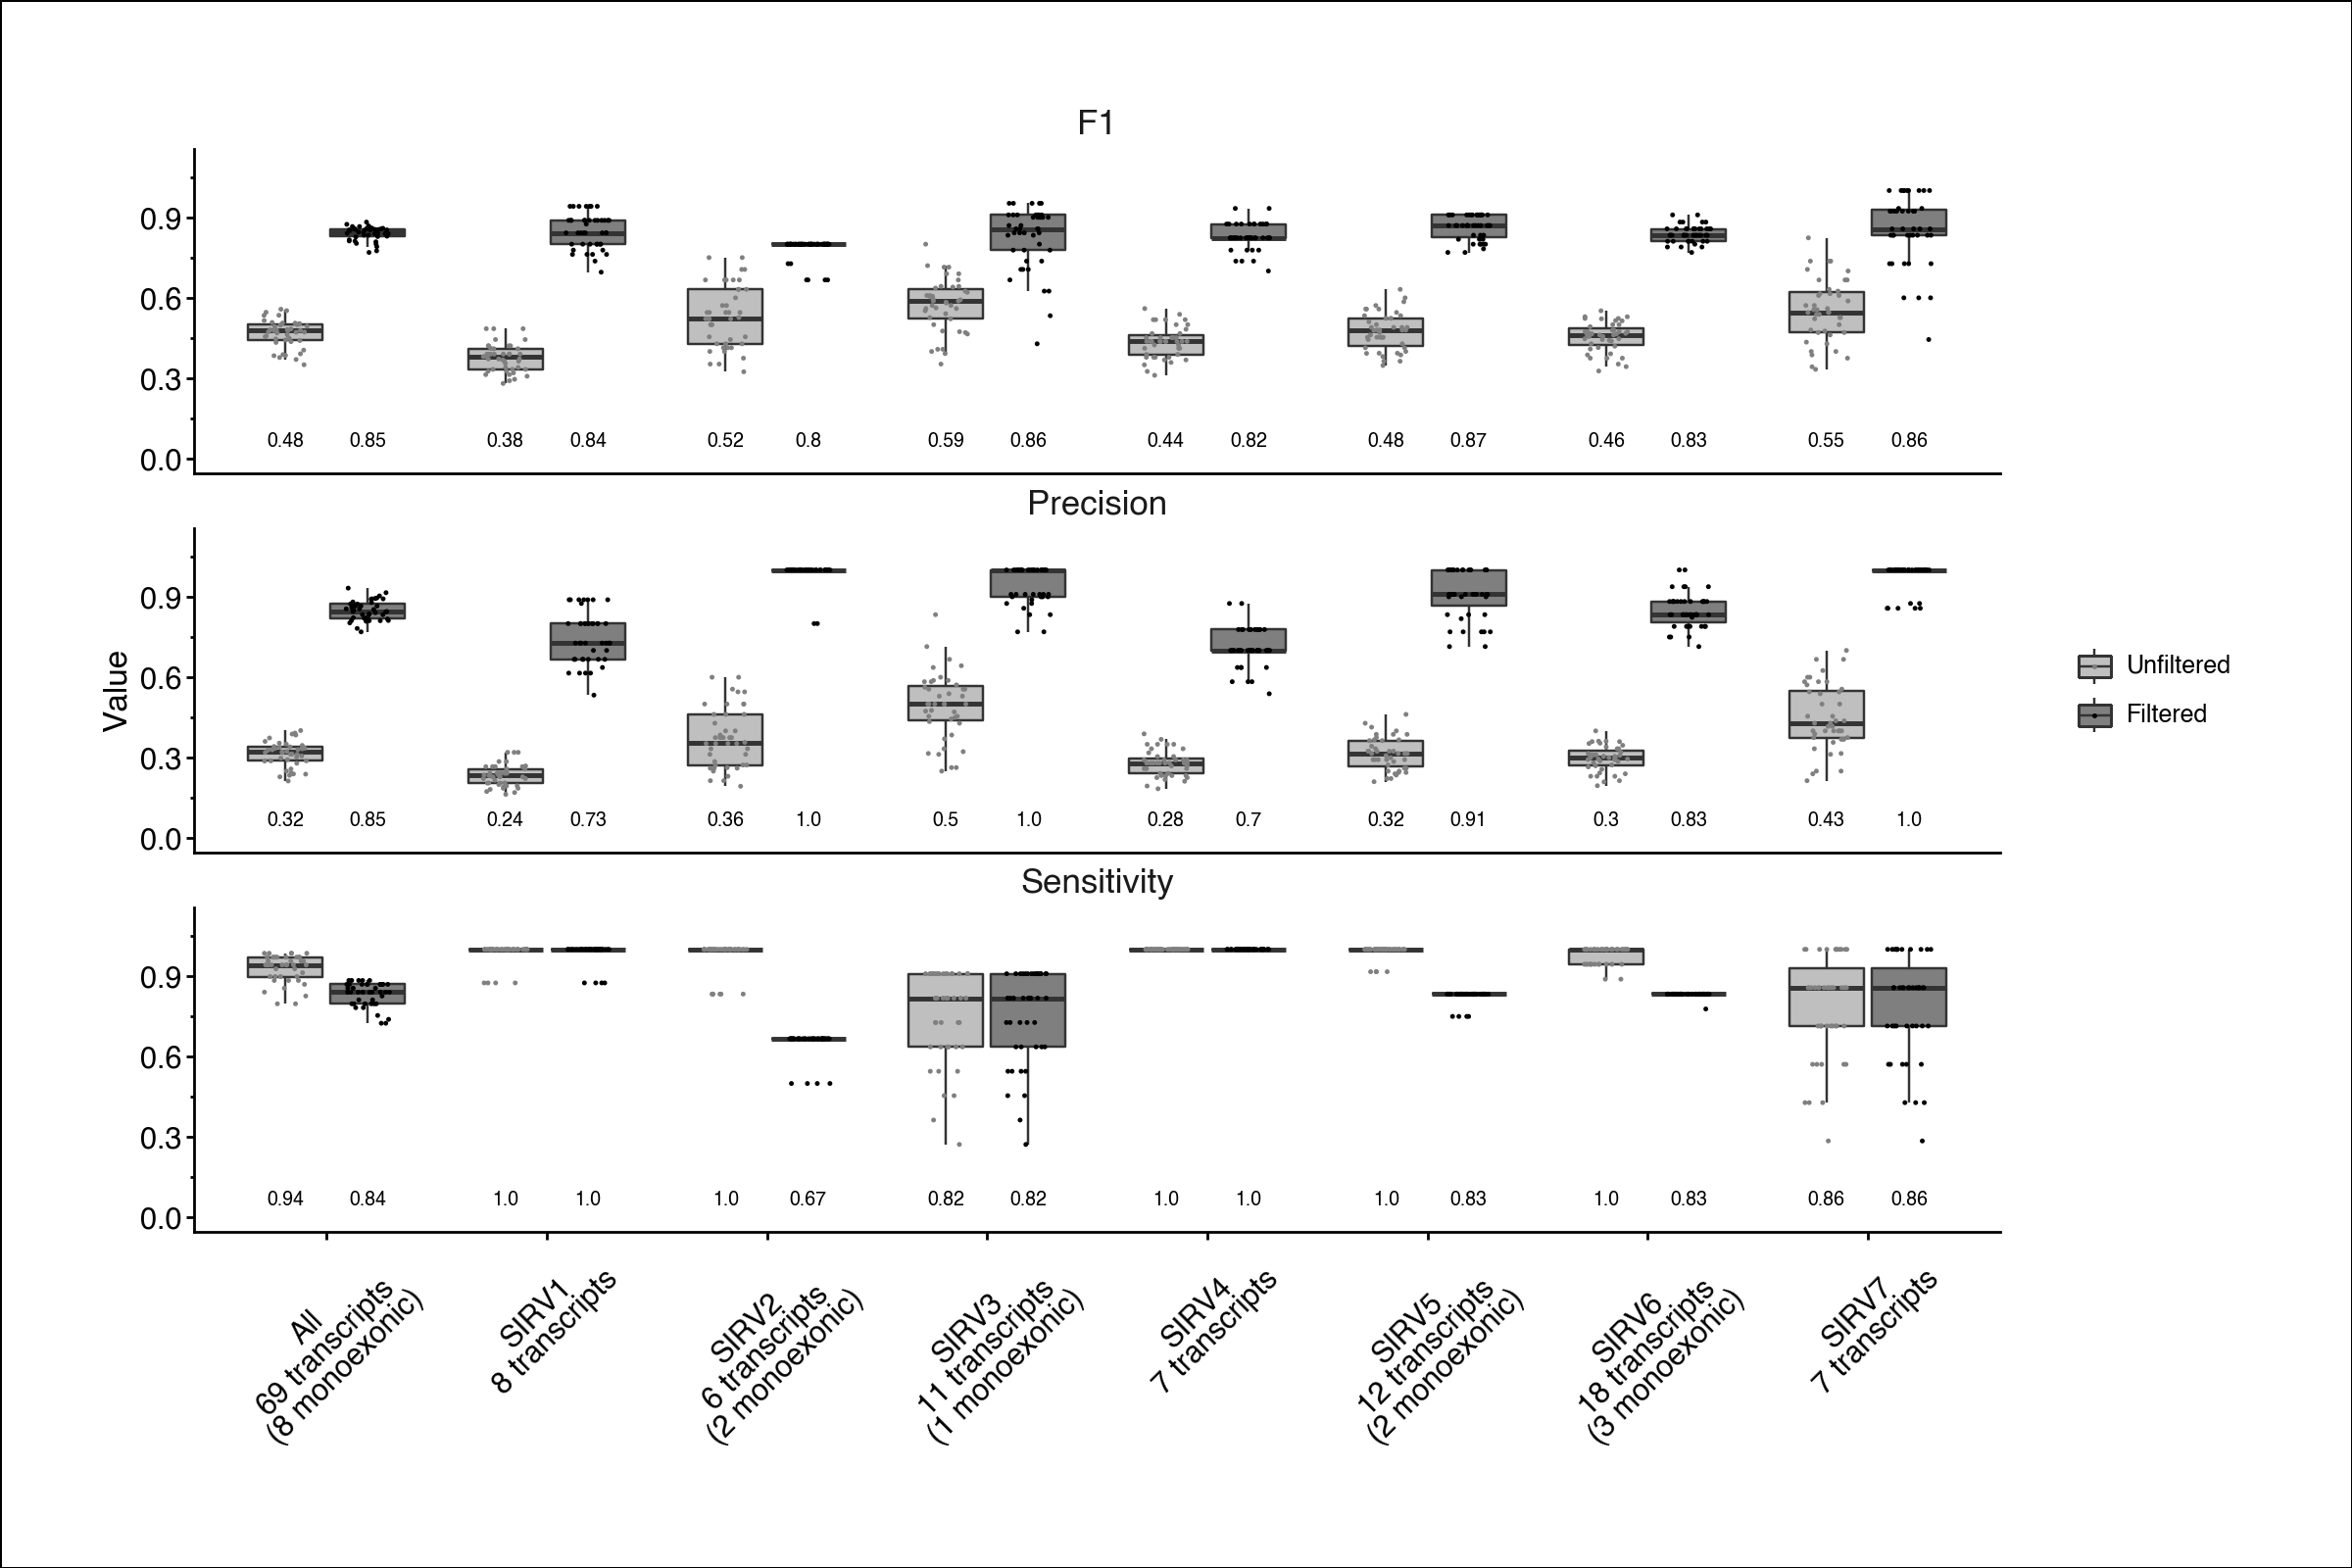

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8.571428571428571 x 5.7142857142857135 in image.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: spliced_sirv_prec_sens_f1_filt_unfilt.pdf
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/guides/guides.py:207: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [128]:
medians = stat_melted[['median', 'median_y', 'median_label',
                       'stat_type', 'assc_gene_title', 'filter_set']].drop_duplicates()

p = (
    ggplot(stat_melted, aes(y='stat_val', x='assc_gene_title', fill='filter_set'))
    + geom_boxplot(outlier_shape='', alpha=0.5)
    + geom_point(aes(fill='filter_set'),
         stroke=0,
         size=1, alpha=1,
         position=position_jitterdodge())
    + scale_fill_manual(colorz)
    + facet_wrap('~stat_type', nrow=3)
    + scale_color_manual(values=pop_c_dict)
    + geom_text(
        aes(x='assc_gene_title', 
            y='median_y', 
            label='median_label', 
            fill='filter_set'),  # match color aesthetic
        data=medians,
        inherit_aes=False,
        size=7,
        va='top',
        position=position_dodge(width=0.75)  # align with boxplot dodge
    )
    + my_theme(h=8, w=12)
    + theme(axis_text_x=element_text(rotation=45))
    + labs(
        y='Value',
        x='')
    + ylim(0.0,1.1)
    )
p.show()
p.save('spliced_sirv_prec_sens_f1_filt_unfilt.pdf', width=(12/7)*5, height=(8/7)*5, dpi=500)


In [116]:
# let's compute the average increase in precision overall that 
# applying the filters gives
filt_temp = stat_melted.loc[(stat_melted.assc_gene_2=='All')&\
                            (stat_melted.filter_set=='Filtered')]
assert len(filt_temp.index) == 43*3

unfilt_temp = stat_melted.loc[(stat_melted.assc_gene_2=='All')&\
                            (stat_melted.filter_set=='Unfiltered')]
assert len(unfilt_temp.index) == 43*3

cols = ['stat_val', 'lab_sample', 'stat_type'] 
temp = filt_temp[cols].merge(unfilt_temp[cols], 
                       how='inner',
                       on=['lab_sample', 'stat_type'],
                       suffixes=('_filt', '_unfilt'))

assert len(temp) == 43*3

temp['diff'] = temp['stat_val_filt']-temp['stat_val_unfilt']

In [118]:
temp[['diff', 'stat_type']].groupby('stat_type')['diff'].mean()

stat_type
F1             0.372944
Precision      0.534457
Sensitivity   -0.096057
Name: diff, dtype: float64

In [58]:
# stat_melted.loc[stat_melted.stat_val.isnull()].head()
# temp2[['stat_val', 'filter_set', 'assc_gene_title']].isnull().sum()
